In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import drc_fosa_geolocalisation.data_clean as dc
import drc_fosa_geolocalisation.data_match as dm
import pandas as pd
from geopandas.tools import sjoin
from shapely.geometry import LineString, Polygon, Point
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [3]:
# Reading in data
carte_sanitaire_url = "~/Documents/data/rdc/carte_sanitaire.xlsx"
carte_sanitaire = dc.read_and_clean_carte_sanitaire(carte_sanitaire_url)

kemri_data_url = "~/Documents/data/nature_fosa_data.xlsx"
kemri_data, kemri_drc = dc.read_and_clean_kemri_data(kemri_data_url)

#https://data.humdata.org/dataset/dr-congo-health-0
shape_rdc_url = "/Users/grlurton/Documents/data/rdc/snis/map_polygons.shp"
hierarchy = "/Users/grlurton/Documents/data/rdc/snis/hierarchy.csv"
zones_data = dc.read_and_clean_zones_data(shape_rdc_url, hierarchy)

In [4]:
kemri_drc = kemri_drc[~(kemri_drc.fosa_name== "")]

In [5]:
print("Total N Fosas in Kemri data: " + str(len(kemri_data)))
print("N countries in Kemri data: " + str(kemri_data.country.nunique()))
print("-"*25)
print("N Fosa for the 5 biggest countries")
print(kemri_data.country.value_counts().head())
print("-"*25)
print("Validated DRC Fosas: " + str(len(kemri_drc)))

Total N Fosas in Kemri data: 98745
N countries in Kemri data: 50
-------------------------
N Fosa for the 5 biggest countries
Nigeria                             20807
Democratic Republic of the Congo    14586
Tanzania                             6304
Kenya                                6146
Ethiopia                             5215
Name: country, dtype: int64
-------------------------
Validated DRC Fosas: 14558


The publication of a list of 98745 health facilities in 50 African countries has with reason been hailed as a significant contribution to the field of Global Public Health. This unprecedented work is certainly one of the most comprehensive effort to map health systems across Africa, and could be extremely useful to any professional interested in understanding access to health care. Meanwhile, this important endeavour should be considered a starting point rather than an end in itself. Indeed, in order to be usable, the location of health services should not only be indirectly estimated through secondary data analysis and diverse source compilation. There are regulatory and governance related issues involved in providing a master list of health facilities. In a well functioning system, health authorities are the only actors able to  to accredit a health facility, from which they will in return expect accountability in a form or another. As such, a health facility registry is by nature dynamic, and is a key element of any national health information system.

The Democratic Republic of Congo (DRC) has the second highest number of health facilities according to Kemri's counts, with 14586 facilities, it comes second only to Nigeria and its 20807 facilities. These two countries have more than twice the number of health facilities of any other country in the data set, with the third entry being Tanzania and its 6304 health facilities.

The National Health Information System in DRC (SNIS) uses a facility registry as the backbone of its national routine health database managed with the software DHIS2. Bluesquare, a Belgian company, has been helping the SNIS in updating this registry and using other eligible data sources. The objective of this work is to build an exhaustive list of health facilities with, at least, a validated geolocalisation.

In order to assess how much the Kemri data can contribute to this work, we have conducted a simple matching exercise to compare the list of facilities provided by KEMRI for DRC with the data managed by the SNIS.

In [6]:
kemri_drc.fosa.value_counts().head()

bolingo centre de sante        19
bon berger centre de sante     15
kimbanguiste poste de sante    15
boboto centre de sante         14
uzima centre de sante          13
Name: fosa, dtype: int64

# Data Preparation

## KEMRI Data

KEMRI has reported 14586 health facilities in DRC. These facilities seem to stem from a variety of sources, some which may be quite old, as some are classified in the Lulua and the Kasai Occidental provinces, both of which disappeared in the 2016 provinces reform. We decided to process a cleaning of the data with the following steps 

A second step was to be sure that all facilities in the Kemri data was uniquely identified. To do so, we processed in three steps:
1. We dropped all facilities with non informative names (like "hospital") and units that appeared not to be health facilities (like district health authorities bureau). 28 facilities were dropped in this first stage.
2. We performed a spatial join of the Kemri data with the shapes of health zones as stored in the SNIS database. Indeed, Kemri does not provide zone attribution for health facilities, but in order to ensure unique identification of health facilities, it is important to work at a low level of aggregation, as many facilities are named the same (for example, there are 15 facillities named "kimbanguiste poste de sante" all over DRC). A spatial join is a simple operation, whereby we use the GPS reported for each facility in the DRC data, and we see in which zone it falls.
3. In each zone, we identified clusters of facilities having the same exact name. We identified 850 such clusters, accounting for a total of 1801 facilities.
4. For each cluster of facilities, we determined the centroid, and computed the average distance of facilities to this centroid. The median of the average within cluster distance was 390 meters, and the mean of the average within cluster distance was 3.2 km.
5. For clusters for which facilities were within an average 2km distance of the centroid, we considered them to be different occurences of the same facility. We imputed the GPS of this facility as the centroid of the cluster, and only kept one occurence.
6. For clusters for which facilities were on average distant of more than 2km from the centroid, we dropped all facilities from the units to be matched with the SNIS data, as all the identifying information (name and zone) was identical.

Of the 850 clusters, 617 ended up being considered duplicates of the same facility and 233 were considered non differentiable units.

After these manipulations, the consisted of 12007 facilities to be matched with the SNIS database.

In [7]:
# Spatial Join
kemri_zoned = sjoin(kemri_drc, zones_data, how='left', lsuffix="kemri", rsuffix="zone")

count_fosa_zone = kemri_zoned.groupby(["province_zone","zone","fosa"]).size().reset_index().rename(columns={0:'counts'})
duplicated_fosa_zone = count_fosa_zone.loc[count_fosa_zone.counts > 1]
duplicated_fosa_zone["cluster_zone"] = "cl" + duplicated_fosa_zone.index.astype(str)
print("N Fosa with multiple lines after joint: " + str(len(duplicated_fosa_zone)))
print("N non unique FOSAs after joint: " + str(duplicated_fosa_zone.counts.sum()))

N Fosa with multiple lines after joint: 850
N non unique FOSAs after joint: 1801


/Users/grlurton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
kemri_zoned = kemri_zoned.merge(duplicated_fosa_zone[["province_zone","zone","fosa","cluster_zone"]], how="left")
kemri_zoned = kemri_zoned[~pd.isnull(kemri_zoned.zone)]

cluster_distance_zone = kemri_zoned.groupby(["cluster_zone"]).apply(dm.dist_between_duplicates)

print("Median of within cluster average distance: " + str(cluster_distance_zone.mean_distance.median()))
print("Mean of within cluster average distance: " + str(cluster_distance_zone.mean_distance.mean()))

Median of within cluster average distance: 0.39045900521209964
Mean of within cluster average distance: 3.213520957640798


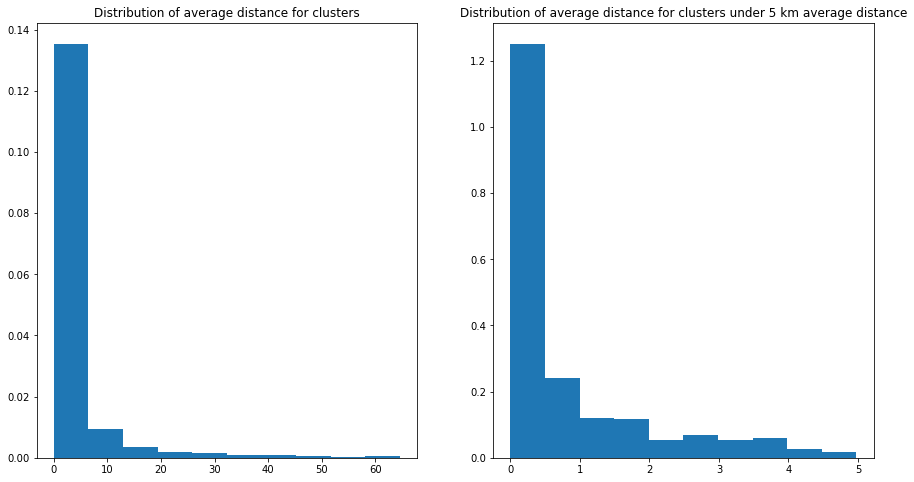

In [18]:
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.hist(cluster_distance_zone.mean_distance, density = True)
plt.title("Distribution of average distance for clusters")
plt.subplot(1, 2, 2)
plt.hist(cluster_distance_zone.mean_distance[cluster_distance_zone.mean_distance <5], density = True)
plt.title("Distribution of average distance for clusters under 5 km average distance")
plt.show()

In [19]:
#Taking out duplicate status

cluster_distance_zone = cluster_distance_zone.reset_index()
kemri_zoned["duplicate"] = ""
kemri_zoned["duplicate_status"] = ""

threshold_distance = 2

for cluster in kemri_zoned.cluster_zone.dropna().unique():
    data_cluster = cluster_distance_zone.loc[(cluster_distance_zone["cluster_zone"] == cluster)]
    if (data_cluster.mean_distance.iloc[0] < threshold_distance) == True:
        kemri_zoned.loc[kemri_zoned.cluster_zone == cluster, "geometry"] = cluster_distance_zone.loc[kemri_zoned.cluster_zone == cluster, "geometry"]
        kemri_zoned.loc[kemri_zoned.cluster_zone == cluster, "duplicate"] = cluster
        kemri_zoned.loc[kemri_zoned.cluster_zone == cluster, "duplicate_status"] = "cluster"
    if (data_cluster.mean_distance.iloc[0] < threshold_distance) == False:
        kemri_zoned.loc[kemri_zoned.cluster_zone == cluster, "duplicate_status"] = "non unique"
        
print(kemri_zoned.groupby("duplicate_status").apply(lambda x : x.cluster_zone.nunique()))

duplicate_status
                0
cluster       617
non unique    233
dtype: int64


In [20]:
# Dropping non unique FOSAs

kemri_zoned.drop_duplicates(["fosa","duplicate"], inplace=True)
kemri_zoned = kemri_zoned[~(kemri_zoned.duplicate_status == "non unique")]
print(len(kemri_zoned))

12007


## SNIS data preparation

The SNIS data slits 17706 facilities. As GPS availability is much less prevalent in this data, we had to implement a more stringent deduping of the data availability selection. We simply performed stages 1 and 6 of the data cleaning. As the result, the SNIS data we work with consists of 17387 facilities.

In [21]:
print(len(carte_sanitaire))
carte_sanitaire = carte_sanitaire.drop_duplicates(["province","zone","fosa"])
carte_sanitaire = carte_sanitaire[~(carte_sanitaire.fosa_name== "")]
print(len(carte_sanitaire))

17706
17387


## Comparison SNIS - KEMRI

We compared the availibity of identifiable health facilities in the two sources in each zone. In 77.6% of health zones, the SNIS data had more health facilities than the Kemri data. In a minority of health zones, Kemri had more health facilities than the SNIS data, with up to 7 times more in the Vuhovi zone of North Kivu. It should be remembered at this point that zone attribution was made based on the spatial joint we performed. It is thus possible that some problems in health facilities' GPS coordinates would put them in the wrong zone with this spatial joint.

In [22]:
kemri_tab = kemri_zoned.groupby(["province_zone","zone"]).apply(len).reset_index()
carte_sanitaire_tab = carte_sanitaire.groupby(["province","zone"]).apply(len).reset_index()
compare = kemri_tab.merge(carte_sanitaire_tab ,suffixes=["_kemri", "_dhis"], left_on = ["province_zone","zone"], right_on=["province","zone"])
compare["fosa_ratio"] = compare["0_kemri"] / compare["0_dhis"]
print(len(kemri_zoned)/len(carte_sanitaire))
print(sum(compare.fosa_ratio < 1)/len(compare))

0.6905734169206879
0.776


Text(0.5, 1.0, 'Ratio of number of Health Facilities between sources by zone')

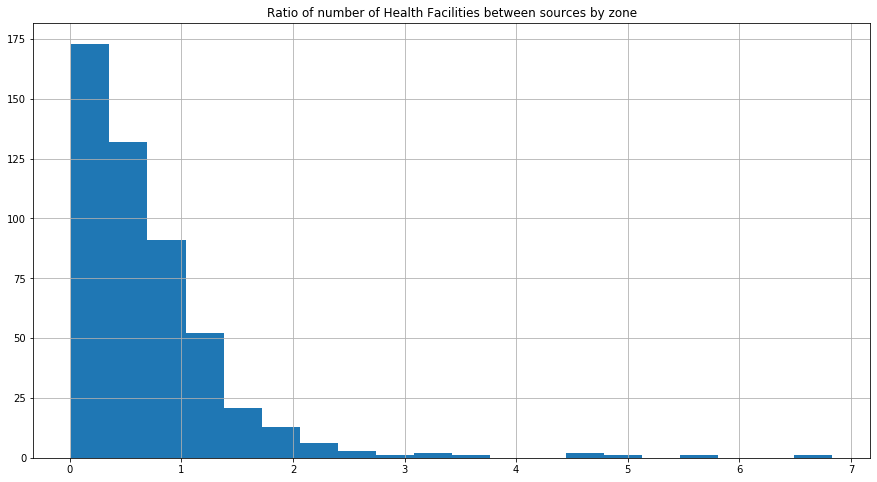

In [23]:
plt.figure(figsize=(15,8))
compare.fosa_ratio.hist(bins = 20) ; 
plt.title("Ratio of number of Health Facilities between sources by zone")

In [24]:
compare.sort_values("fosa_ratio", ascending = False).head()

,province_zone,zone,0_kemri,province,0_dhis,fosa_ratio
378,nord kivu,vuhovi,123,nord kivu,18,6.833333
43,haut katanga,lubumbashi,568,haut katanga,101,5.623762
475,tshopo,makiso kisangani,133,tshopo,27,4.925926
205,kinshasa,selembao,139,kinshasa,30,4.633333
31,haut katanga,kambove,143,haut katanga,31,4.612903


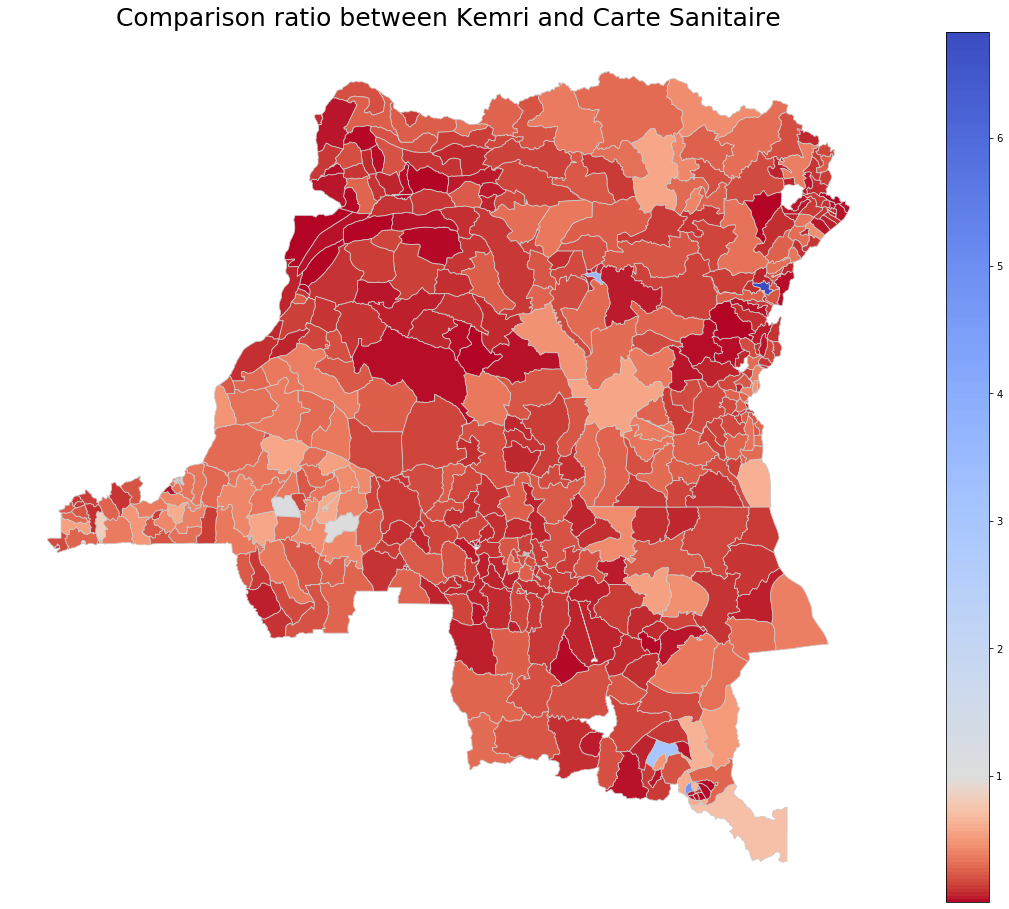

In [28]:
map_compare = zones_data.merge(compare)

fig, ax = plt.subplots(1, figsize=(20, 16))
map_compare.plot(column="fosa_ratio", cmap="coolwarm_r", ax=ax, linewidth=0.8, edgecolor="0.8")
ax.axis('off')
ax.set_title("Comparison ratio between Kemri and Carte Sanitaire", fontdict={'fontsize': '25', 'fontweight' : '3'});
sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=dm.MidpointNormalize(midpoint=1., 
                                                                  vmin=map_compare.fosa_ratio.min(), 
                                                                   vmax=map_compare.fosa_ratio.max()))
sm._A = []
cbar = fig.colorbar(sm)

# Matching FOSAs

We use a very simple algorithm to match health facilities between the two registries. Using the splitted health facility name for each health facility in DHIS,we find the best match based on Levenshtein distance in the corresponding zone in the Kemri data. We then similarly find the best match for the Kemri name in the DHIS listing for the zone. If the best match is the same as the starting point, we consider the two values to be matched.

We run three complete iterations of this algorithm on each zone. After the first round, 6500 matches were made. After the second round, 1509 additional matches were made. After the third round, only 624 additional matches were made. 

Out of these 8633 matches, we have GPS distances for both sides of the match for only 3764 matches. Using these matches, we can estimate the distance between matched entities. We see that for health facilities with string distance over 86, the median distance is less than 100 meters. While subsetting on string distance, we can get addi GPS for 18% of facilities which are lacking GPS coordinates in the Carte Sanitaire with a reasonable degree of confidence in the correctness of these coordinates.

In [30]:
matched = pd.DataFrame()
carte_to_match = carte_sanitaire.drop_duplicates(["province","zone","fosa_name"], keep=False)
kemri_to_match = kemri_zoned.drop(["ownership","index_zone","zone_id","province_kemri"], axis = 1).drop_duplicates(["province_zone","zone","fosa_name"], keep=False)

kemri_n = len(kemri_to_match)
for i in range(3):
    print("Round " + str(i + 1))
    matched_i = carte_to_match.groupby(["province","zone"]).apply(lambda x : dm.love_machine(x, kemri_to_match, x.name))
    matched_i = matched_i.drop(["province","index"], axis = 1)
    matched_i = matched_i.reset_index(drop=True)
    print("        N new Matches: " + str(len(matched_i)))
    matched_i["n_round"] = str(i + 1)
    matched = matched.append(matched_i).reset_index(drop=True)
    carte_to_match = carte_to_match[~carte_to_match.dhis2_id.isin(matched.dhis2_id)]
    kemri_to_match = kemri_to_match[~kemri_to_match.kemri_id.isin(matched.kemri_id)]

Round 1
        N new Matches: 6500
Round 2
        N new Matches: 1509
Round 3
        N new Matches: 624


In [31]:
#Compute distances

compare_gps_dhis_dist  = matched.dropna(subset = ["geometry_kemri","geometry_snis"])
dhis_gps = gpd.GeoDataFrame(compare_gps_dhis_dist.dhis2_id,geometry=compare_gps_dhis_dist.geometry_snis,crs={'init':'epsg:4326'})
dhis_gps = dhis_gps.to_crs(epsg=3310)
kemri_gps = gpd.GeoDataFrame(compare_gps_dhis_dist.kemri_id, geometry=compare_gps_dhis_dist.geometry_kemri,crs={'init':'epsg:4326'})
kemri_gps = kemri_gps.to_crs(epsg=3310)

compare_gps_dhis_dist["distances"] = dhis_gps.distance(kemri_gps) / 1000
compare_gps_dhis_dist = compare_gps_dhis_dist[compare_gps_dhis_dist.distances < 1.797693e+305]
print("N Matches with two GPS coordinates: " + str(len(compare_gps_dhis_dist)))

N Matches with two GPS coordinates: 3764


/Users/grlurton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Text(0.5, 0, 'String distance')

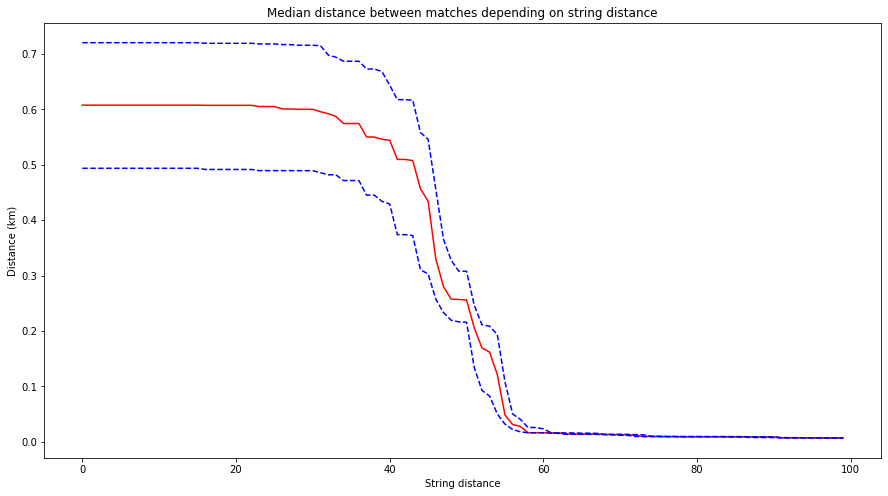

In [36]:
#check distance vs string distance

cutoffs = list(range(100))
out = pd.DataFrame({"cutoff":cutoffs})

for i in range(200):
    sample = compare_gps_dhis_dist.sample(frac=.8, replace = False)
    mean_dist = []
    for cutoff in cutoffs:
        dat_cut = sample[sample.name_distance >= cutoff]
        mean_dist = mean_dist + [dat_cut.distances.median()]
    out = out.merge(pd.DataFrame({"cutoff":cutoffs, "sample_" + str(i):mean_dist}))
    
plt.figure(figsize=(15,8))
plt.plot(cutoffs , out.drop("cutoff", axis = 1).apply(np.median, axis = 1), color="red")
plt.plot(cutoffs , out.drop("cutoff", axis = 1).apply(lambda x : np.quantile(x, .025), axis = 1), "b--")
plt.plot(cutoffs , out.drop("cutoff", axis = 1).apply(lambda x : np.quantile(x, .975), axis = 1), "b--")
plt.title("Median distance between matches depending on string distance")
plt.ylabel("Distance (km)")
plt.xlabel("String distance")

Text(0.5, 1.0, 'Distribution of string distance')

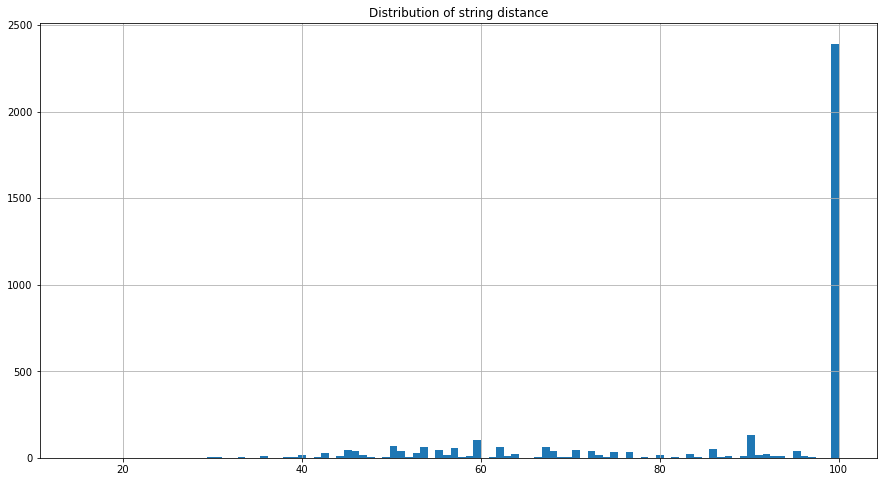

In [356]:
plt.figure(figsize=(15,8))
compare_gps_dhis_dist.name_distance.hist(bins=100) ;
plt.title("Distribution of string distance")

In [338]:
matched = dm.matching_metrics(matched, 86)

Raw Number Matches: 8633
Raw % matched in Kemri: 0.7525934966437102
-----------------------
Matches over string_threshold : 4961
% matched over string_threshold in Kemri: 0.4324819109057624


In [358]:
additional_gps = sum(pd.isnull(matched.geometry_snis.apply(lambda x: x.x))) / sum(pd.isnull(carte_sanitaire.geometry.apply(lambda x: x.x)))
print("% of additional GPS obtained: " + str(additional_gps))

% of additional GPS obtained: 0.17622118187439273
